Import Necessary Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
means   = np.array([-2.0, 1.0, 5.0])
stds    = np.array([0.8, 0.3, 0.5])
mix     = np.array([2, 5, 3])
mix = mix / np.sum(mix)
total = 1000

<Axes: ylabel='Density'>

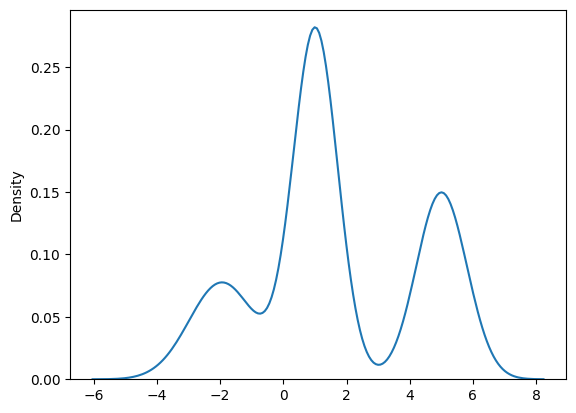

In [3]:
data = np.array([])
for mu, std, mix_ratio in zip(means, stds, mix):
    data = np.append(data, np.random.normal(loc=mu, scale=std, size=int(total*mix_ratio)))

sns.kdeplot(data, label='Normal Distribution PDF')

In [4]:
steps = 1000
betas = np.linspace(start=1e-4, stop=0.02, num=steps)
alphas = 1 - betas
alphaBar = []
for i in range(steps):
    alphaBar.append(np.prod(alphas[:i+1]))
alphaBar = np.array(alphaBar)

In [5]:
X = []
labels = []

for x in data:
    for t in range(steps):

        epsilon = np.random.normal()

        x_t = x * np.sqrt(alphaBar[t]) + epsilon * np.sqrt(1 - alphaBar[t])
        timeVal = float(t + 1) / float(steps)

        data_point = [x_t, timeVal]

        X.append(data_point)
        labels.append(epsilon)  

X = np.array(X)  
labels = np.array(labels)

<Axes: ylabel='Density'>

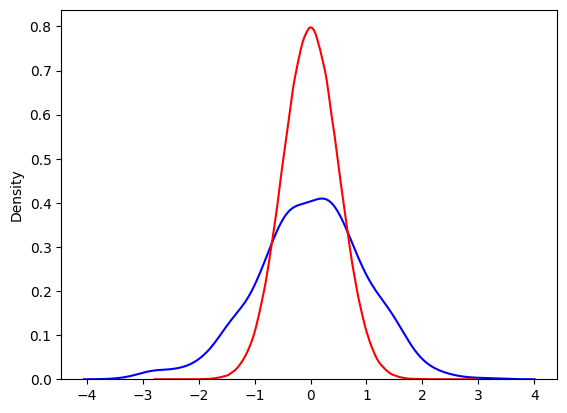

In [6]:
condition = 1.0
checkData = X[X[:, 1] == condition, 0]
sns.kdeplot(checkData, label=f"Data at {condition * steps} step", color='blue')
sns.kdeplot(np.random.normal(loc=0.0, scale=std, size=steps*total), color='red')

In [7]:
class DDPM(nn.Module):
    def __init__(self):
        super(DDPM, self).__init__()

        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 1)
        self.act = nn.GELU()

    def forward(self, data):
        data = self.act(self.fc1(data))
        data = self.act(self.fc2(data))
        data = self.act(self.fc3(data))
        data = self.fc4(data)
        return data

In [8]:
class myDataSet(torch.utils.data.Dataset):
  def __init__(self, data, targets):
    self.data = data
    self.targets = targets

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data_point = self.data[index]
    target = self.targets[index]

    data_point = torch.tensor(data_point).float()  
    target = torch.tensor(target).float()

    return data_point, target


In [69]:
dataSet = myDataSet(X, labels)

In [78]:
data_loader = torch.utils.data.DataLoader(dataSet, batch_size=8192, shuffle=True)

In [9]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
model = DDPM()
model = torch.compile(model)
epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
model.to(device)
torch.set_float32_matmul_precision('high')

In [79]:
for epoch in tqdm(range(epochs)):
    avgLoss = 0.0
    n_iter = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        eps_theta = model(data).reshape(-1)
        loss = criterion(eps_theta, target)
        loss.backward()
        optimizer.step()

        avgLoss += loss.item()
        n_iter += 1
    # print(f"epoch: {epoch}|loss: {avgLoss / n_iter}")

  1%|          | 1/100 [00:18<30:51, 18.70s/it]

epoch: 0|loss: 0.38214938857560266


  2%|▏         | 2/100 [00:37<30:45, 18.83s/it]

epoch: 1|loss: 0.38114097324373286


  3%|▎         | 3/100 [00:56<30:16, 18.73s/it]

epoch: 2|loss: 0.3801333548954416


  4%|▍         | 4/100 [01:14<29:51, 18.66s/it]

epoch: 3|loss: 0.3793693048334804


  5%|▌         | 5/100 [01:33<29:36, 18.70s/it]

epoch: 4|loss: 0.3784558142864875


  6%|▌         | 6/100 [01:52<29:16, 18.68s/it]

epoch: 5|loss: 0.3776301296698291


  7%|▋         | 7/100 [02:11<29:05, 18.77s/it]

epoch: 6|loss: 0.37694706165961206


  8%|▊         | 8/100 [02:29<28:44, 18.75s/it]

epoch: 7|loss: 0.3762114030939426


  9%|▉         | 9/100 [02:48<28:35, 18.85s/it]

epoch: 8|loss: 0.3755137666846589


 10%|█         | 10/100 [03:07<28:09, 18.77s/it]

epoch: 9|loss: 0.37487782400809916


 11%|█         | 11/100 [03:26<27:50, 18.77s/it]

epoch: 10|loss: 0.3740739962562218


 12%|█▏        | 12/100 [03:44<27:27, 18.72s/it]

epoch: 11|loss: 0.37337150590795193


 13%|█▎        | 13/100 [04:03<26:58, 18.60s/it]

epoch: 12|loss: 0.37289889751036476


 14%|█▍        | 14/100 [04:21<26:43, 18.65s/it]

epoch: 13|loss: 0.3722508301032833


 15%|█▌        | 15/100 [04:39<25:54, 18.29s/it]

epoch: 14|loss: 0.37170636269943846


 16%|█▌        | 16/100 [04:57<25:27, 18.18s/it]

epoch: 15|loss: 0.3710114390328374


 17%|█▋        | 17/100 [05:16<25:22, 18.34s/it]

epoch: 16|loss: 0.3705746016497505


 18%|█▊        | 18/100 [05:34<25:15, 18.48s/it]

epoch: 17|loss: 0.3700550379562963


 19%|█▉        | 19/100 [05:53<24:57, 18.48s/it]

epoch: 18|loss: 0.369522183219348


 20%|██        | 20/100 [06:12<24:42, 18.53s/it]

epoch: 19|loss: 0.36904474337164367


 21%|██        | 21/100 [06:30<24:29, 18.60s/it]

epoch: 20|loss: 0.3685215806059067


 22%|██▏       | 22/100 [06:49<24:09, 18.59s/it]

epoch: 21|loss: 0.3679997999609614


 23%|██▎       | 23/100 [07:08<23:53, 18.61s/it]

epoch: 22|loss: 0.3675953600182367


 24%|██▍       | 24/100 [07:26<23:31, 18.57s/it]

epoch: 23|loss: 0.3672089321359779


 25%|██▌       | 25/100 [07:45<23:17, 18.63s/it]

epoch: 24|loss: 0.3667950302910951


 26%|██▌       | 26/100 [08:03<22:58, 18.63s/it]

epoch: 25|loss: 0.36647138999039897


 27%|██▋       | 27/100 [08:21<22:19, 18.35s/it]

epoch: 26|loss: 0.3660077392323617


 28%|██▊       | 28/100 [08:38<21:40, 18.06s/it]

epoch: 27|loss: 0.3655962866020593


 29%|██▉       | 29/100 [08:56<21:18, 18.01s/it]

epoch: 28|loss: 0.36519603379421195


 30%|███       | 30/100 [09:15<21:17, 18.25s/it]

epoch: 29|loss: 0.364833192469396


 31%|███       | 31/100 [09:34<21:05, 18.34s/it]

epoch: 30|loss: 0.3645875121796302


 32%|███▏      | 32/100 [09:53<20:56, 18.47s/it]

epoch: 31|loss: 0.364122648302519


 33%|███▎      | 33/100 [10:11<20:29, 18.36s/it]

epoch: 32|loss: 0.36365344791324594


 34%|███▍      | 34/100 [10:30<20:22, 18.53s/it]

epoch: 33|loss: 0.3633733800705713


 35%|███▌      | 35/100 [10:48<20:06, 18.57s/it]

epoch: 34|loss: 0.362982596965899


 36%|███▌      | 36/100 [11:07<19:47, 18.56s/it]

epoch: 35|loss: 0.36248439873410637


 37%|███▋      | 37/100 [11:26<19:37, 18.69s/it]

epoch: 36|loss: 0.3621106064270854


 38%|███▊      | 38/100 [11:44<19:18, 18.68s/it]

epoch: 37|loss: 0.3616264275977948


 39%|███▉      | 39/100 [12:03<19:04, 18.76s/it]

epoch: 38|loss: 0.3611692008552863


 40%|████      | 40/100 [12:22<18:40, 18.68s/it]

epoch: 39|loss: 0.36079444335525995


 41%|████      | 41/100 [12:41<18:25, 18.73s/it]

epoch: 40|loss: 0.3601030355704099


 42%|████▏     | 42/100 [12:59<18:05, 18.72s/it]

epoch: 41|loss: 0.35966266627692006


 43%|████▎     | 43/100 [13:18<17:49, 18.77s/it]

epoch: 42|loss: 0.3592755858517863


 44%|████▍     | 44/100 [13:37<17:28, 18.73s/it]

epoch: 43|loss: 0.358634481278909


 45%|████▌     | 45/100 [13:55<17:07, 18.69s/it]

epoch: 44|loss: 0.3583230997887126


 46%|████▌     | 46/100 [14:14<16:49, 18.69s/it]

epoch: 45|loss: 0.3577878037600917


 47%|████▋     | 47/100 [14:33<16:32, 18.73s/it]

epoch: 46|loss: 0.3572503383783719


 48%|████▊     | 48/100 [14:52<16:16, 18.78s/it]

epoch: 47|loss: 0.3568677652345357


 49%|████▉     | 49/100 [15:11<16:03, 18.89s/it]

epoch: 48|loss: 0.35641565510587947


 50%|█████     | 50/100 [15:30<15:39, 18.80s/it]

epoch: 49|loss: 0.35602740422348306


 51%|█████     | 51/100 [15:48<15:20, 18.79s/it]

epoch: 50|loss: 0.3556568200846635


 52%|█████▏    | 52/100 [16:07<14:57, 18.70s/it]

epoch: 51|loss: 0.3553880288557041


 53%|█████▎    | 53/100 [16:25<14:36, 18.65s/it]

epoch: 52|loss: 0.3550499915954769


 54%|█████▍    | 54/100 [16:44<14:20, 18.71s/it]

epoch: 53|loss: 0.3548259643689255


 55%|█████▌    | 55/100 [17:03<14:01, 18.70s/it]

epoch: 54|loss: 0.35453056673574546


 56%|█████▌    | 56/100 [17:22<13:45, 18.76s/it]

epoch: 55|loss: 0.3544667630107856


 57%|█████▋    | 57/100 [17:40<13:24, 18.71s/it]

epoch: 56|loss: 0.35416973703721794


 58%|█████▊    | 58/100 [17:59<13:09, 18.80s/it]

epoch: 57|loss: 0.3539419613610991


 59%|█████▉    | 59/100 [18:18<12:48, 18.74s/it]

epoch: 58|loss: 0.35374893305979377


 60%|██████    | 60/100 [18:37<12:27, 18.70s/it]

epoch: 59|loss: 0.35358943663735576


 61%|██████    | 61/100 [18:56<12:12, 18.78s/it]

epoch: 60|loss: 0.3533910820089235


 62%|██████▏   | 62/100 [19:14<11:51, 18.71s/it]

epoch: 61|loss: 0.35345172851607354


 63%|██████▎   | 63/100 [19:33<11:33, 18.75s/it]

epoch: 62|loss: 0.3532169706860447


 64%|██████▍   | 64/100 [19:52<11:13, 18.70s/it]

epoch: 63|loss: 0.3532816673227127


 65%|██████▌   | 65/100 [20:10<10:48, 18.52s/it]

epoch: 64|loss: 0.3529832653228978


 66%|██████▌   | 66/100 [20:28<10:30, 18.54s/it]

epoch: 65|loss: 0.35309401763972575


 67%|██████▋   | 67/100 [20:47<10:14, 18.62s/it]

epoch: 66|loss: 0.35278756755017554


 68%|██████▊   | 68/100 [21:06<09:55, 18.62s/it]

epoch: 67|loss: 0.3527247031164072


 69%|██████▉   | 69/100 [21:24<09:38, 18.66s/it]

epoch: 68|loss: 0.35272355569652253


 70%|███████   | 70/100 [21:43<09:22, 18.75s/it]

epoch: 69|loss: 0.3526728117880402


 71%|███████   | 71/100 [22:02<09:03, 18.73s/it]

epoch: 70|loss: 0.35267613837324036


 72%|███████▏  | 72/100 [22:21<08:46, 18.79s/it]

epoch: 71|loss: 0.3525330780230173


 73%|███████▎  | 73/100 [22:40<08:26, 18.76s/it]

epoch: 72|loss: 0.3524548483894403


 74%|███████▍  | 74/100 [22:58<08:07, 18.76s/it]

epoch: 73|loss: 0.3524966171670301


 75%|███████▌  | 75/100 [23:17<07:50, 18.82s/it]

epoch: 74|loss: 0.3524334464824029


 76%|███████▌  | 76/100 [23:36<07:29, 18.74s/it]

epoch: 75|loss: 0.3523257377810761


 77%|███████▋  | 77/100 [23:55<07:12, 18.79s/it]

epoch: 76|loss: 0.3522880134041324


 78%|███████▊  | 78/100 [24:14<06:52, 18.77s/it]

epoch: 77|loss: 0.35229043568082624


 79%|███████▉  | 79/100 [24:33<06:35, 18.83s/it]

epoch: 78|loss: 0.35216754936976913


 80%|████████  | 80/100 [24:51<06:15, 18.76s/it]

epoch: 79|loss: 0.3521301776231676


 81%|████████  | 81/100 [25:10<05:56, 18.74s/it]

epoch: 80|loss: 0.3520879026936607


 82%|████████▏ | 82/100 [25:29<05:38, 18.79s/it]

epoch: 81|loss: 0.3519970001862337


 83%|████████▎ | 83/100 [25:47<05:17, 18.68s/it]

epoch: 82|loss: 0.35201924344513313


 84%|████████▍ | 84/100 [26:06<04:59, 18.74s/it]

epoch: 83|loss: 0.3520491602840112


 85%|████████▌ | 85/100 [26:25<04:41, 18.75s/it]

epoch: 84|loss: 0.3519613015139761


 86%|████████▌ | 86/100 [26:44<04:22, 18.74s/it]

epoch: 85|loss: 0.3519019099954203


 87%|████████▋ | 87/100 [27:02<04:04, 18.78s/it]

epoch: 86|loss: 0.35192650069000775


 88%|████████▊ | 88/100 [27:21<03:45, 18.78s/it]

epoch: 87|loss: 0.35191208361848


 89%|████████▉ | 89/100 [27:40<03:26, 18.74s/it]

epoch: 88|loss: 0.35186147007230356


 90%|█████████ | 90/100 [27:59<03:07, 18.77s/it]

epoch: 89|loss: 0.35171127563117716


 91%|█████████ | 91/100 [28:18<02:49, 18.81s/it]

epoch: 90|loss: 0.35180497900839963


 92%|█████████▏| 92/100 [28:36<02:29, 18.74s/it]

epoch: 91|loss: 0.35180743486603344


 93%|█████████▎| 93/100 [28:55<02:10, 18.66s/it]

epoch: 92|loss: 0.3515879815341505


 94%|█████████▍| 94/100 [29:13<01:51, 18.65s/it]

epoch: 93|loss: 0.3515895172984078


 95%|█████████▌| 95/100 [29:32<01:33, 18.71s/it]

epoch: 94|loss: 0.35153063528376854


 96%|█████████▌| 96/100 [29:51<01:15, 18.80s/it]

epoch: 95|loss: 0.3515221581381035


 97%|█████████▋| 97/100 [30:10<00:56, 18.72s/it]

epoch: 96|loss: 0.351586809187579


 98%|█████████▊| 98/100 [30:29<00:37, 18.78s/it]

epoch: 97|loss: 0.3514422890720679


 99%|█████████▉| 99/100 [30:48<00:18, 18.83s/it]

epoch: 98|loss: 0.3515245559756741


100%|██████████| 100/100 [31:06<00:00, 18.67s/it]

epoch: 99|loss: 0.3514312680026017


In [93]:
torch.save(model.state_dict(), "/home/arnabdey/Placement ML projects/.vscode/Diffusion/myModel.pt")

In [11]:
model.load_state_dict(torch.load("/home/arnabdey/Placement ML projects/.vscode/Diffusion/myModel.pt"))

<All keys matched successfully>

Sampling

In [127]:
generation_Samples = np.random.normal(loc=0.0, scale=1.0, size=1024)
generation_Samples = torch.from_numpy(generation_Samples).to(device)
gen_DataSet = torch.utils.data.DataLoader(generation_Samples, batch_size= 256, shuffle=False)

In [64]:
# torch._dynamo.config.suppress_errors = True

In [128]:
sampled_data = []
with torch.no_grad():
    for x_t in tqdm(gen_DataSet):

        for t in range(steps, 0, -1):

            z = np.random.normal(loc=0.0, scale=1.0, size=x_t.shape) if t > 1 else np.array([0.0])
            z = torch.from_numpy(z).to(device)
            # data_point = torch.Tensor([x_t, float(t) / 1000.0]).to(device)
            dpt = torch.column_stack((x_t, (float(t) / 1000.0) * torch.ones(x_t.shape[0]).to(device))).to(torch.float32).to(device)
            epsilon_theta = model(dpt)

            x_t = (np.sqrt(alphas[t-1]))**-1.0 * (x_t - epsilon_theta.reshape(-1) * betas[t-1]/np.sqrt(1 - alphaBar[t-1])) + np.sqrt(betas[t-1]) * z
        
        sampled_data.append(x_t.reshape(-1))

sampled_data = np.array(torch.concatenate(sampled_data).to('cpu'))

100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


[]

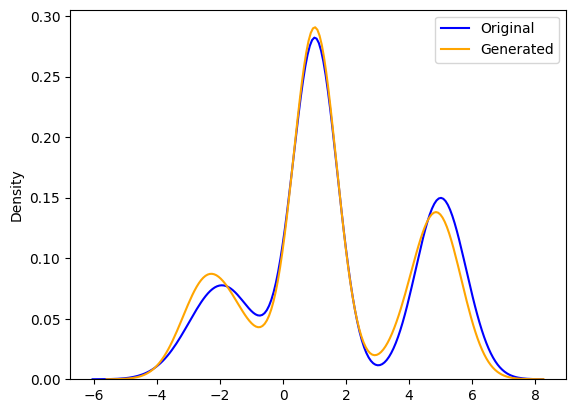

In [129]:
sns.kdeplot(X[X[:, 1] == 0.001, 0], color='blue', label='Original')
sns.kdeplot(sampled_data, color='orange', label='Generated')
plt.legend()
plt.plot()